# CMB Map Examples

Our goal is to make rectangular maps that have properties that are reasonably similar to CMB-S4's "ultradeep" survey with the SATs and SPLAT.

We start by working in a "flat signal" map domain, adding in noise as given in CMB-S4's "measurement requirements".


In [481]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 8]

def make_ell_arrays(N,pix_size_arcmin):
    # Given square real-space map pix_size (in arcminutes) and N=number of pixels across one edge,
    # return the 2D fourier space arrays ell_x and ell_y.
    
    pix_radians = (pix_size_arcmin/60.) * (np.pi/180.)  # pixel size in radians
    
    # make kx,ky 2D arrays
    # that run from -k_nyquist to zero to +k_nyquist
    # (so k=0 is in the center of these arrays)
    inds  = (np.arange(N) - N/2.) /(N-1.)  # runs from about -1/2, to 0, to 1/2
    krange = inds/pix_radians
    kx,ky = np.meshgrid(krange,krange)
    
    # Convert to ell from k
    ell_x = 2*np.pi * kx
    ell_y = 2*np.pi * ky
    
    return(ell_x, ell_y)

def make_noise_map(N,pix_size_arcmin,ell, N_ell):
    '''
    Makes a realization of a noise map with a given N_ell.
    
    Inputs:
        N = number of pixels across the side of the square map.
        pix_size_arcmin = pixel size in arcminuts
        ell = numpy array containing ell values to consider.
        N_ell = numpy array of N_ell values, same size as ell array.
    '''
    
    # Make the ell2d array that will be used to shape the white noise
    # in Fourier space.
    #
    ell_x, ell_y = make_ell_arrays(N, pix_size_arcmin)
    ell2d = np.sqrt(ell_x**2 + ell_y**2)
    
    # Make a white noise map with random numbers in the 
    # specified pixel size, scaled such that the rms would
    # be unity if the pixels were 1rad x 1rad.
    #
    pixrad = (pix_size_arcmin /60.* np.pi/180.)
    whitenoisemap = np.random.normal(0,1,(N,N))/pixrad
    
    # Interpolate 1D N_ell array into 2D array at ells given by ell2d
    Nell2D = np.interp(ell2d,ell,N_ell,right=0)  # This is centered.
    
    # Shape the white noise map by multiplying by sqrt(Nell2D) in Fourier space.
    FT_noise_map = np.fft.fft2(whitenoisemap)
    FT_shaped_noise_map = np.fft.fftshift(FT_noise_map)*np.sqrt(Nell2D)
    #
    # Inverse FFT back to get to real space.  (fftshift before iFFT-ing.)
    noise_map = np.real(np.fft.ifft2(np.fft.fftshift(FT_shaped_noise_map)))
    
    return(noise_map)

def make_CMB_maps(N,pix_size,ell,DlTT,DlEE,DlTE,DlBB):
    "makes a realization of a simulated CMB sky map - adapted from CMB Summer School notebook 7"

    # We need power spectrum value assignments at every point in our ell_x, ell_y grids.
    # The power spectra depend only on the magnitude of ell, so calculate that.
    # (These are 2D arrays)
    ell_x, ell_y = make_ell_arrays(N, pix_size)
    ell2d = np.sqrt(ell_x**2 + ell_y**2)

    # convert Dl to Cl, we use np.divide to avoid dividing by zero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = np.divide(DlTT, dell, where=ell>1)
    ClEE = np.divide(DlEE, dell, where=ell>1)
    ClTE = np.divide(DlTE, dell, where=ell>1)
    ClBB = np.divide(DlBB, dell, where=ell>1)
    
    # set the \ell = 0 (monopole) and \ell =1 (dipole) modes to zero as 
    # the primordial parts of those are not measureable, and the first blows 
    # up with the above transform
    ClTT = np.where(ell>1,ClTT,0)
    ClEE = np.where(ell>1,ClEE,0)
    ClTE = np.where(ell>1,ClTE,0)
    CLBB = np.where(ell>1,ClBB,0)
    #ClTT[0:2] = 0.
    #ClEE[0:2] = 0.
    #ClTE[0:2] = 0.
    #ClBB[0:2] = 0.

    # separate the correlated and uncorrelated part of the EE spectrum
    correlated_part_of_E = np.divide(ClTE, np.sqrt(ClTT), where=ell>1)      #this keeps the sign of the correlation intact
    uncorrelated_part_of_EE = ClEE - np.divide(ClTE**2., ClTT, where=ell>1) #This keeps EE positive definite.
    correlated_part_of_E = np.where(ell>1,correlated_part_of_E,1e-9)
    uncorrelated_part_of_EE = np.where(ell>1,uncorrelated_part_of_EE,1e-9)

    # Create 2D Fourier-plane versions of those C_ell's.
    # The values of our ell2d array are probably not integers.
    # We can interpolate the power spectra we read in (at integer values of ell)
    # and pad with zeros if we exceed the maximum ell we read in.
    #
    CLTT2d        = np.interp(ell2d,ell,ClTT) #,                   right=0)
    CLBB2d        = np.interp(ell2d,ell,ClBB) #,                   right=0)
    CLEE_uncor_2d = np.interp(ell2d,ell,uncorrelated_part_of_EE)  #,right=0)
    CLE_corr2d    = np.interp(ell2d,ell,correlated_part_of_E)#,   right=0)

    # now make a set of gaussian random fields that will be turned into the CMB maps
    # Doing it this way (using fft2) is nice in that it takes care of some normalization issues.
    random_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    random_array_for_E = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    random_array_for_B = np.fft.fft2(np.random.normal(0,1,(N,N))) 
    
    ## make the T, E, and B (Fourier) maps by multiplying the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * random_array_for_T 
    FE_2d = np.sqrt(CLEE_uncor_2d) * random_array_for_E + CLE_corr2d* random_array_for_T
    FB_2d = np.sqrt(CLBB2d) * random_array_for_B
    
    ## now convert E abd B to Q and U
    ang = np.arctan2(ell_y,ell_x)   ## we now need this angle to handle the EB <--> QU rotation
    FQ_2d = FE_2d* np.cos(2.*ang) - FB_2d * np.sin(2. *ang)
    FU_2d = FE_2d* np.sin(2.*ang) + FB_2d * np.cos(2. *ang)
    
    #delta_ell = (ell_x[0,1]-ell_x[0,0])
    pixrad = (pix_size /60.* np.pi/180.)
    #print('Delta_ell = ',delta_ell,'   1/pixrad = ',1/pixrad)
    
    ## convert from fourier space to real space
    # JR:  I really don't understand why one needs to divide by pixrad here.
    #      I suspect it's up in the whitenoise map generation step.
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) / pixrad
    CMB_T = np.real(CMB_T)
    CMB_Q = np.fft.ifft2(np.fft.fftshift(FQ_2d)) / pixrad
    CMB_Q = np.real(CMB_Q)
    CMB_U = np.fft.ifft2(np.fft.fftshift(FU_2d)) / pixrad
    CMB_U = np.real(CMB_U)

    ## optional code for spitting out E and B maps 
    CMB_E = np.fft.ifft2(np.fft.fftshift(FE_2d)) / pixrad
    CMB_E = np.real(CMB_E)
    CMB_B = np.fft.ifft2(np.fft.fftshift(FB_2d)) / pixrad
    CMB_B = np.real(CMB_B)
    
    ## return the maps
    return(CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B)
    


## CMB map + Shaped Noise map.

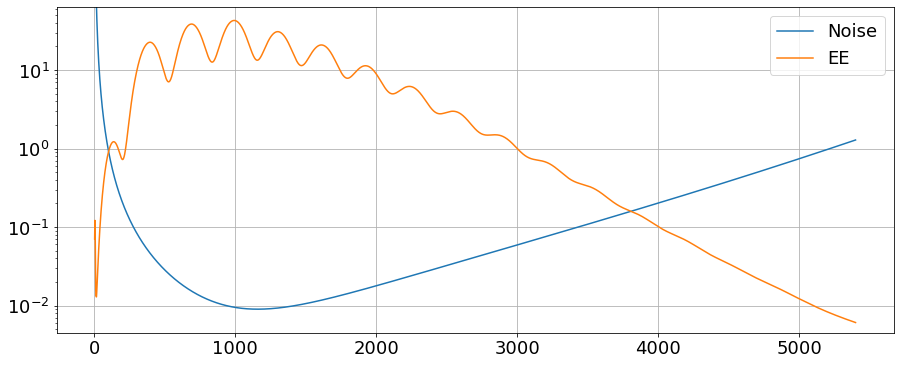

In [484]:
# Make a CMB map, and noise map
N = 1000  # pixels across one side of the map
pix_size_arcmin = 2.5 # arcminutes

# Read in the CMB power spectra, 
# this sets the ell range that we'll concern ourselves with.
#
ell, DlTT,DlEE,DlBB, DlTE= np.loadtxt("CMB_fiducial_totalCls.dat", usecols=(0, 1,2,3,4), unpack=True) 



# Set up the noise properties
pixrad = (pix_size_arcmin /60.* np.pi/180.)

# Following CMB-S4's parameterization of N_ell
ell_noise = np.arange(1,25000)  # ells over which to create initial noise curve

# beam factor
fwhm = 2.5* (1/60.)*(np.pi/180.)  # radians
beam_factor = np.exp(ell*(ell+1)*fwhm**2 / (8*np.log(2)))

# low ell "1/ell" factor (actually 1/ell^alpha )
ell_knee = 1200.
alpha = 4.2
knee_factor = (1 + (ell_knee/ell)**alpha)

# "white noise" map depth parameter
delta_uKarcmin = 0.45
delta_uKrad = delta_uKarcmin*(np.pi/60./180.)

# Put those all together to make the 1D N(ell) vector
N_ell  = np.where(ell>1,(delta_uKrad**2)*beam_factor*knee_factor,0)
Noise_Dell = N_ell*ell*(ell+1)/(2*np.pi)

# Plot the N_ell, in D_ell units, and the EE signal
plt.rcParams['figure.figsize'] = [15, 6]
plt.semilogy(ell,Noise_Dell, label = "Noise")
plt.ylim(0.5*np.min(Noise_Dell),1.5*np.max(DlEE))
plt.semilogy(ell,DlEE, label="EE")
plt.legend()
plt.grid()


## Make Signal + Noise map

We could just make maps from these spectra.  However, the noise blows up at low and high ell, and that would dominate the map.  We could "Wiener filter" by signal-to-noise weighting the modes before making the map, but let's just proceed by only using modes where the signal is larger than the N_ell. 


rms of E-mode:  6.4655395048700095
rms of noise map:  0.673011941882625


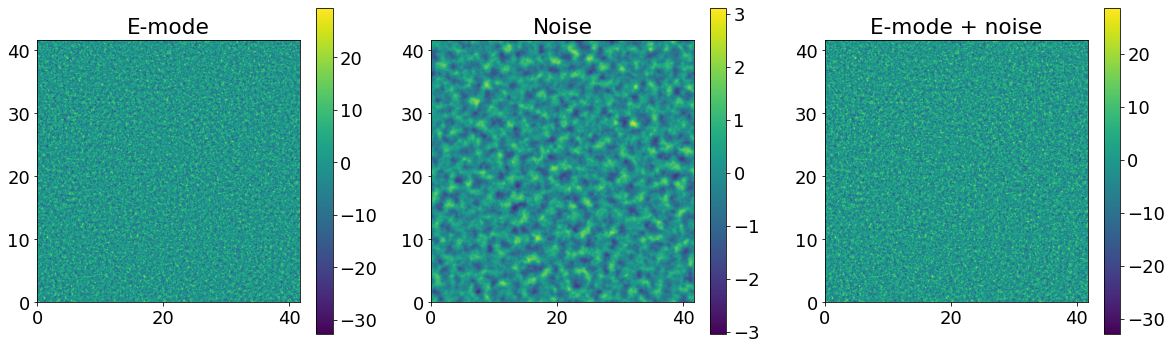

In [480]:
N_ell_filt = np.where(Noise_Dell<DlEE,N_ell,1e-9*N_ell)
DlEE_filt  = np.where(Noise_Dell<DlEE,DlEE,1e-9*DlEE)
DlTT_filt  = np.where(Noise_Dell<DlEE,DlTT,1e-9*DlTT)
DlTE_filt  = np.where(Noise_Dell<DlEE,DlTE,1e-9*DlTE)



# Use that N_ell to make a noise map.
noisemap = make_noise_map(N,pix_size,ell,N_ell_filt)

CMB_T,CMB_Q,CMB_U,CMB_E,CMB_B = make_CMB_maps(N,pix_size,ell,DlTT_filt,DlEE_filt,DlTE_filt,DlBB)

plt.rcParams['figure.figsize'] = [20, 6]

xsize = N*pix_size/60. # degrees
plt.subplot(1,3,1)
plt.imshow(CMB_E,extent = (0,xsize,0,xsize))
plt.title('E-mode')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(noisemap,extent = (0,xsize,0,xsize))
plt.title('Noise')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(CMB_E+noisemap,extent = (0,xsize,0,xsize))
plt.title('E-mode + noise')
plt.colorbar()


print('rms of E-mode: ',np.std(CMB_E))
print('rms of noise map: ',np.std(noisemap))